In [1]:
import numpy as np 
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential 
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D

In [2]:
# Load data
train_dir = r'C:\Documents\Documents\Germany\1SRH\Project\Drowsiness system\Req_Data\train'
test_dir = r'C:\Documents\Documents\Germany\1SRH\Project\Drowsiness system\Req_Data\test'

In [3]:
BS=32
#Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=BS,
    class_mode='binary', color_mode = 'grayscale')

validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=BS, subset='validation',
    class_mode='binary', color_mode = 'grayscale')

Found 76409 images belonging to 2 classes.
Found 15281 images belonging to 2 classes.


In [4]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2)

In [5]:
SPE= len(train_data.classes)//BS
VS = len(validation_data.classes)//BS
print(SPE,VS)

2387 477


In [6]:
#Reference for CNN - https://www.youtube.com/watch?v=u3FLVbNn9Os 
### Define CNN architecture
model = Sequential()

# First Convolution Layer
model.add(Conv2D(64, (3,3), input_shape =(64,64,1), activation = 'relu'))
#Activation function-Relu, NonLinear, <0 reject
model.add(MaxPooling2D(pool_size = (2,2)))

# Second Convolution Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# Third Convolution Layer
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add (Dropout(0.25))

###Fully flattened layer 
model.add (Flatten())
#Layer 1
model.add (Dense(32, activation = 'relu'))
model.add (Dropout(0.5))

#layer 2
model.add (Dense(1, activation = 'sigmoid'))

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
model.fit(train_data, validation_data=validation_data, epochs=5, steps_per_epoch=SPE ,validation_steps=VS)

Epoch 1/5
2387/2387 [==============================] - 468s 196ms/step - loss: 0.3427 - accuracy: 0.8437 - val_loss: 0.1713 - val_accuracy: 0.9409
Epoch 2/5
2387/2387 [==============================] - 441s 185ms/step - loss: 0.1423 - accuracy: 0.9503 - val_loss: 0.0674 - val_accuracy: 0.9788
Epoch 3/5
2387/2387 [==============================] - 494s 207ms/step - loss: 0.1065 - accuracy: 0.9635 - val_loss: 0.0622 - val_accuracy: 0.9796
Epoch 4/5
2387/2387 [==============================] - 397s 166ms/step - loss: 0.0942 - accuracy: 0.9674 - val_loss: 0.0479 - val_accuracy: 0.9831
Epoch 5/5
2387/2387 [==============================] - 358s 150ms/step - loss: 0.0851 - accuracy: 0.9709 - val_loss: 0.0427 - val_accuracy: 0.9855


In [9]:
model.save(r'C:\Documents\Documents\Germany\1SRH\Project\Drowsiness system\Req_Data\DDcnnModel.h5', overwrite=True)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 64)         0

In [12]:
#Evaluating model on the test data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=BS,
    class_mode='binary', color_mode = 'grayscale')
model.evaluate(test_data)

Found 8489 images belonging to 2 classes.
266/266 [==============================] - 27s 103ms/step - loss: 0.1473 - accuracy: 0.9448


[0.14727631211280823, 0.944752037525177]

In [13]:
import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from pygame import mixer

pygame 2.1.3 (SDL 2.0.22, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [14]:
#Importing the haar cascade classifiers for face and eye detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
model = load_model(r'C:\Documents\Documents\Germany\1SRH\Project\Drowsiness system\Req_Data\DDcnnModel.h5')

In [19]:
#lb1=['Closed', 'Open']
mixer.init()
sound= mixer.Sound(r'C:\Documents\Documents\Germany\1SRH\Project\Drowsiness system\alarm.wav')
cap = cv2.VideoCapture(0)
Score=0
thicc=2
count=0
while True:
    ret, frame = cap.read()
    #print(frame.shape,"frame")
    height,width = frame.shape[0:2]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces= face_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=3)
    eyes= eye_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=6)
    
    cv2.rectangle(frame, (0,height-50),(200,height),(0,0,0),thickness=cv2.FILLED)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,pt1=(x,y),pt2=(x+w,y+h), color= (255,0,0), thickness=1 )
        
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (255,0,0), thickness=1 )
        
        # preprocessing steps
        eye= frame[ey:ey+eh,ex:ex+w]
        eye = cv2.cvtColor(eye,cv2.COLOR_BGR2GRAY)
        #eye= cv2.resize(eye,(80,80))
        eye= cv2.resize(eye,(64,64)) #resizing the live image as our model was trained on 64X64 pixel
        #g= cv2.resize(eye,(64,64))
        #print(g.shape, "g")
        eye= eye/255 #Normalizing it, so we have values 0-1
        #eye= eye.reshape(80,80,3)
        eye= eye.reshape(64,64,-1)
        eye= np.expand_dims(eye,axis=0)
        # preprocessing is done now model prediction
        prediction = model.predict(eye)
        #print(prediction)
        
        # if eyes are closed
        if prediction[0]<0.30:
            count=count+1
            print(prediction,"closed")
            cv2.putText(frame,'closed',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                        thickness=1,lineType=cv2.LINE_AA)
            
            cv2.putText(frame,'Score'+str(Score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                        thickness=1,lineType=cv2.LINE_AA)
            
            Score=Score+1
            if(Score>15):
                cv2.putText(frame,"DROWSY",(20,100),
                cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,255),4)
                cv2.putText(frame,"Are you Sleepy?",(20,400),
                cv2.FONT_HERSHEY_SIMPLEX,2,(0,0,255),4)
                try:
                    sound.play()
                except:
                    pass
                    
                if(thicc<16):
                    thicc=thicc+2
                else:
                    thicc=thicc-2
                    if(thicc<2):
                        thicc=2
                cv2.rectangle(frame,(0,0),(width,height),(0,0,255),thicc)
            
        # if eyes are open
        elif prediction[0]>0.50:
            count=count+1
            print(prediction,"open")
            cv2.putText(frame,'open',(10,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                        thickness=1,lineType=cv2.LINE_AA)      
            cv2.putText(frame,'Score'+str(Score),(100,height-20),fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                        thickness=1,lineType=cv2.LINE_AA)
            Score = Score-1
            if (Score<0):
                Score=0
            
        
    cv2.imshow('frame',frame)
    if cv2.waitKey(33) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
[[0.22346309]] closed
1/1 [==============================] - 0s 19ms/step
[[0.00123677]] closed
1/1 [==============================] - 0s 19ms/step
[[0.00782106]] closed
1/1 [==============================] - 0s 17ms/step
[[0.24036945]] closed
1/1 [==============================] - 0s 25ms/step
[[0.14871223]] closed
1/1 [==============================] - 0s 29ms/step
[[0.9535229]] open
1/1 [==============================] - 0s 29ms/step
[[0.99215066]] open
1/1 [==============================] - 0s 22ms/step
[[0.89968497]] open
1/1 [==============================] - 0s 22ms/step
[[0.9759135]] open
1/1 [==============================] - 0s 28ms/step
[[0.8570138]] open
1/1 [==============================] - 0s 22ms/step
[[0.9435623]] open
1/1 [==============================] - 0s 20ms/step
[[0.85317004]] open
1/1 [==============================] - 0s 19ms/step
[[0.81225365]] open
1/1 [==============================] - 0s 19ms/step
[[0.87

# Testing on sample image using same code

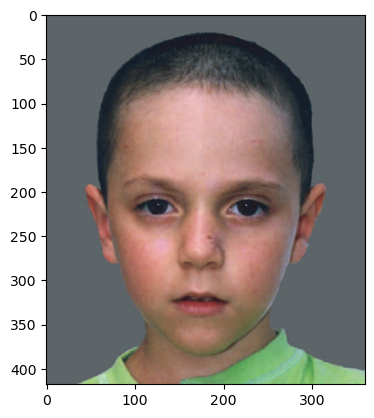

In [95]:
frame = cv2.imread(r'C:\Documents\Documents\Germany\1SRH\Project\TestImages\kid.png')
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces= face_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=3)
eyes= eye_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=6)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

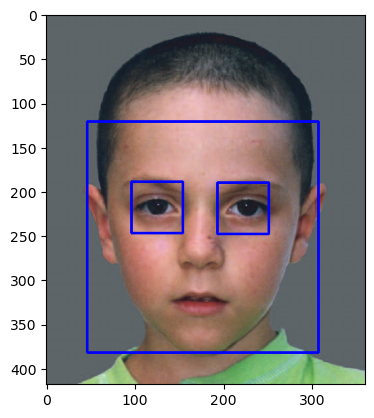

In [96]:
#Drawing rectangles on face and eyes detected
for (x,y,w,h) in faces:
    cv2.rectangle(frame,pt1=(x,y),pt2=(x+w,y+h), color= (255,0,0), thickness=2 )
        
for (ex,ey,ew,eh) in eyes:
    cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (255,0,0), thickness=2 )
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

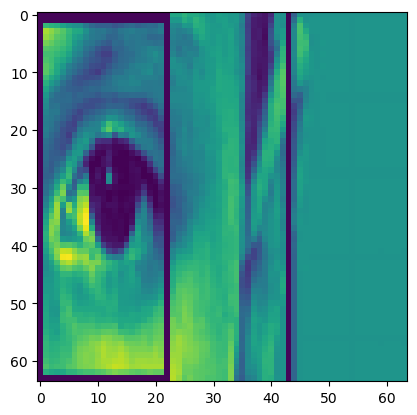

In [97]:
#Croping eyes
for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (255,0,0), thickness=1 )
        
        # preprocessing steps
        eye= frame[ey:ey+eh,ex:ex+w]
        eye = cv2.cvtColor(eye,cv2.COLOR_BGR2GRAY)
        eye= cv2.resize(eye,(64,64)) #resizing the live image as our model was trained on 64X64 pixel
        #print(eye.shape)
        eye= eye/255 #Normalizing it, so we have values 0-1
        #eye= eye.reshape(80,80,3)
        eye= eye.reshape(64,64,-1)
        #eye= np.expand_dims(eye,axis=0)
        plt.imshow(eye)

1/1 [==============================] - 0s 21ms/step
[[0.9929535]] open eyes
1/1 [==============================] - 0s 18ms/step
[[0.9795866]] open eyes


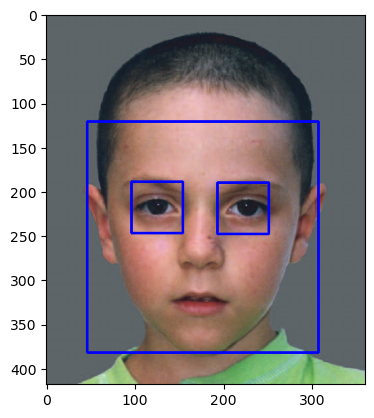

In [98]:
#Passing the image through the trainned model for predictions
for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (255,0,0), thickness=1 )
        
        # preprocessing steps
        eye= frame[ey:ey+eh,ex:ex+w]
        eye = cv2.cvtColor(eye,cv2.COLOR_BGR2GRAY)
        eye= cv2.resize(eye,(64,64)) #resizing the live image as our model was trained on 64X64 pixel
        #print(eye.shape)
        eye= eye/255 #Normalizing it, so we have values 0-1
        #eye= eye.reshape(80,80,3)
        eye= eye.reshape(64,64,-1)
        eye= np.expand_dims(eye,axis=0)
        #plt.imshow(eye)
        prediction = model.predict(eye)
        if prediction[0]>0.50:
            print(prediction,"open eyes")
        elif prediction[0]<0.50:
            print(prediction,"Closed eyes")
        
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        #plt.imshow(cv2.cvtColor(eye, cv2.COLOR_BGR2RGB))

In [45]:
print(model.predict(eye))

1/1 [==============================] - 0s 40ms/step
[[0.74377996]]


In [32]:

prediction1 = np.round(prediction)

In [33]:
prediction1

array([[0.]], dtype=float32)

In [21]:
a=model.predict(test_generator)

266/266 [==============================] - 13s 48ms/step


In [27]:
test_generator.dtype

'float32'

In [22]:
prediction2 = np.round(a)
prediction2

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]], dtype=float32)

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(test_generator.classes, prediction2)
cm

array([[2225, 1969],
       [2205, 2090]], dtype=int64)

In [44]:
len(prediction2)

8489

In [25]:
print(classification_report(test_generator.classes, prediction2))

              precision    recall  f1-score   support

           0       0.50      0.53      0.52      4194
           1       0.51      0.49      0.50      4295

    accuracy                           0.51      8489
   macro avg       0.51      0.51      0.51      8489
weighted avg       0.51      0.51      0.51      8489



In [20]:
# Open the default webcam
cap = cv2.VideoCapture(0)

while True:
    # Read a frame from the webcam
    ret, frame = cap.read()

    # Display the captured frame
    cv2.imshow('frame', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all windows
cap.release()
cv2.destroyAllWindows()

In [37]:
height

480

In [38]:
width

640

In [43]:
eye.shape

(1, 64, 64, 1)